In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read
df = pd.read_csv('data/full_data_flightdelay.csv')
df.head()


,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


Scores for each fold: [0.67483925 0.67519052 0.6743229  0.67464145 0.67449823]
Mean f1 score: 0.675


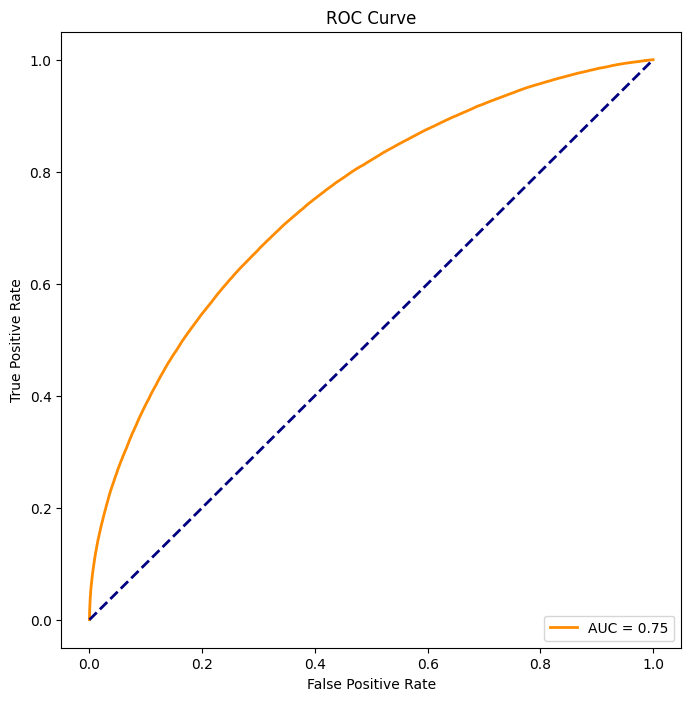

Accuracy: 0.687529954215319
Confusion Matrix:
[[363943 162227]
 [ 40537  82200]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78    526170
           1       0.34      0.67      0.45    122737

    accuracy                           0.69    648907
   macro avg       0.62      0.68      0.61    648907
weighted avg       0.79      0.69      0.72    648907



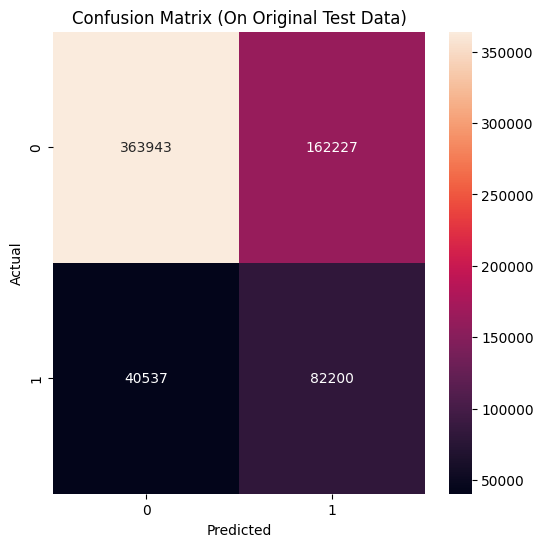

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns



# Select features and target
selected_features = ['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
                      'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
                      'CARRIER_NAME', 'PLANE_AGE', 'DEPARTING_AIRPORT', 'LATITUDE',
                      'LONGITUDE', 'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD',
                      'TMAX', 'AWND']

target = 'DEP_DEL15'



# Encode categorical variables
label_encoders = {}
for column in ['DEP_TIME_BLK', 'CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Separate features and target
X = df[selected_features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Standardize numerical variables
scaler = StandardScaler()
numerical_columns = ['MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP', 'SEGMENT_NUMBER',
                      'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'PLANE_AGE',
                      'LATITUDE', 'LONGITUDE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']

X_train_resampled[numerical_columns] = scaler.fit_transform(X_train_resampled[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

'''
Best parameters
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

'''  

# Define Random Forest model
rf_model = RandomForestClassifier(random_state=42, bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=cv, scoring='f1')

# Print the mean of the cross-validation scores
print(f'Scores for each fold: {scores}')
print(f'Mean f1 score: {scores.mean():.3f}')

# Train Random Forest classifier
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display metrics
# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, cmap='rocket', fmt='g', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (On Original Test Data)')
plt.show()
